In [1]:
import numpy as np
from numpy import random

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import math

In [5]:
from scipy.stats import bernoulli

# Functions

In [6]:
def sample_service_rates(num_jobs, parameter):
    a = parameter
    return 1/np.array([math.floor(t)+100 for t in random.pareto(a, num_jobs)])

In [7]:
def remaining_jobs(remaining):
    return np.array([i for i in range(N) if remaining[i] >= 0.5])

def holding_cost(mean_values, jobs):
    return np.sum([mean_values[i] for i in jobs])

In [8]:
def select_job(t, samples, mean_values, service_rates, jobs):
    for i in jobs:
        samples[i].append(bernoulli.rvs(mean_values[i], size=1)[0])
    c_mu = np.array([(np.mean(samples[i][0:t+1]) * service_rates[i]) for i in jobs])
    return jobs[np.argmax(c_mu)]

def serve(i, service_rate, remaining):
    remaining[i] = (1 - bernoulli.rvs(service_rate, size=1)[0])
    if remaining[i] >= 0.5:
        return 0
    else:
        return 1

In [9]:
def optimal(mean_values, service_rates):
    sorted_jobs = np.argsort(- mean_values * service_rates)
    #print(sorted_jobs)
    total_cost = 0
    for i in range(N):
        for j in range(N):
            if j>= i:
                total_cost += mean_values[sorted_jobs[j]] / service_rates[sorted_jobs[i]]
    return total_cost

In [10]:
def optimal_rule(mean_values, service_rates):
    sorted_jobs = np.argsort(- mean_values * service_rates)
    total_cost = 0
    active_jobs = np.array(range(N))
    remaining = np.ones(N)
    for i in range(N):
        served = 0
        while not served:
            total_cost += holding_cost(mean_values, active_jobs)
            served = serve(sorted_jobs[i], service_rates[sorted_jobs[i]], remaining)
            if served:
                active_jobs = remaining_jobs(remaining)    
    return total_cost

In [11]:
def preemptive(mean_values, service_rates, samples):
    total_cost = 0
    active_jobs = np.array(range(N))
    remaining = np.ones(N)
    t = 0
    while active_jobs.size >= 1:
        total_cost += holding_cost(mean_values, active_jobs)
        chosen_job = select_job(t, samples, mean_values, service_rates, active_jobs)
        served = serve(chosen_job, service_rates[chosen_job], remaining)
        if served:
            active_jobs = remaining_jobs(remaining)
        t += 1
    return total_cost

In [12]:
def nonpreemptive(mean_values, service_rates, samples):
    total_cost = 0
    remaining = np.ones(N)
    t = 0
    for i in range(N):
        active_jobs = remaining_jobs(remaining)
        selected = select_job(t, samples, mean_values, service_rates, active_jobs)
        served = 0
        while not served:
            total_cost += holding_cost(mean_values, active_jobs)
            served = serve(selected, service_rates[selected], remaining)
            t += 1
            for i in active_jobs:
                samples[i].append(bernoulli.rvs(mean_values[i], size=1)[0])
    return total_cost

In [13]:
def preemptive_then_nonpreemptive(mean_values, service_rates, samples):
    max_service_time = np.max(1/service_rates)
    S = math.floor( (max_service_time**(2/3)) * (np.log(N*max_service_time)) / C)
    S = np.min([math.floor(np.min(1/service_rates)), S])
    
    total_cost = 0
    active_jobs = np.array(range(N))
    remaining = np.ones(N)

    for t in range(S):
        total_cost += holding_cost(mean_values, active_jobs)
        selected = select_job(t, samples, mean_values, service_rates, active_jobs)
        served = serve(selected, service_rates[selected], remaining)
        if served:
            active_jobs = remaining_jobs(remaining)
    
    t = S
    for i in range(active_jobs.size):
        selected = select_job(t, samples, mean_values, service_rates, active_jobs)
        served = 0 
        while not served:
            total_cost += holding_cost(mean_values, active_jobs)
            served = serve(selected, service_rates[selected], remaining)
            if served:
                active_jobs = remaining_jobs(remaining)
            t += 1
            for i in active_jobs:
                samples[i].append(bernoulli.rvs(mean_values[i], size=1)[0])
    return total_cost

In [14]:
def create_output_files_geo():
    column_labels = ['num_jobs', 'service_time', 'eps', 'instance_number', 'rep_number', 'OPT', 
                     'preemptive', 'non-preemptive', 'pre-non-pre']
    df = pd.DataFrame(columns=column_labels)
    df.to_csv('results_geo.csv', index=False)

In [15]:
create_output_files_geo()

In [16]:
eps_list = np.array([0.1*i for i in range(6)])
eps_list[0] = 0.001

In [ ]:
it_num = 100
repetition = 100

N = 5
C = 10
 
for eps in eps_list:
    for i in range(it_num):
        mean_values = np.random.uniform(0.5-eps, 0.5+eps, N)
        service_rates = np.array([1/1000 for i in range(N)])
        max_service_time = np.max(1/service_rates)
        S = math.floor( (max_service_time**(2/3)) * (np.log(N*max_service_time)) / C)
        
        trials_p = np.array([])
        for j in range(repetition):
            samples = [(bernoulli.rvs(mean_values[n], size=1)).tolist() for n in range(N)]
            trials_p = np.append(trials_p, preemptive(mean_values, service_rates, samples))

        trials_nonp = np.array([])
        for j in range(repetition):
            samples = [(bernoulli.rvs(mean_values[n], size=1)).tolist() for n in range(N)]
            trials_nonp = np.append(trials_nonp, nonpreemptive(mean_values, service_rates, samples))
    
        trials_pnonp = np.array([])
        for j in range(repetition):
            samples = [(bernoulli.rvs(mean_values[n], size=1)).tolist() for n in range(N)]
            trials_pnonp = np.append(trials_pnonp, preemptive_then_nonpreemptive(mean_values, service_rates, samples))
        
        pre = np.mean(trials_p)
        non = np.mean(trials_nonp)
        pre_non_pre = np.mean(trials_pnonp)
        OPT = optimal(mean_values, service_rates)
        
        df = pd.read_csv('results_geo.csv')
        df = df.append({'num_jobs': N, 'service_time': 1000, 'eps': eps, 'instance_number': i+1, 'rep_number': j+1, 
                        'OPT': OPT, 'preemptive': pre, 'non-preemptive': non, 'pre-non-pre': pre_non_pre}, 
                       ignore_index = True)
        df.to_csv('results_geo.csv', index=False)

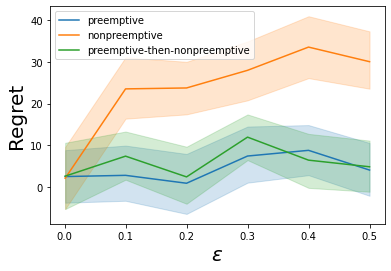

In [53]:
df = pd.read_csv('results/geo/uniform/results_geo.csv')
filt = (df['num_jobs'] == 5) & (df['service_time'] == 20000)
filtered = df[filt]
sns.lineplot(x=filtered['eps'], y=filtered['preemptive']-filtered['OPT'], label='preemptive')
sns.lineplot(x=filtered['eps'], y=filtered['non-preemptive']-filtered['OPT'], label='nonpreemptive')
sns.lineplot(x=filtered['eps'], y=filtered['pre-non-pre']-filtered['OPT'], label='preemptive-then-nonpreemptive')
plt.xlabel(r'$\epsilon$', fontsize=20)
plt.ylabel("Regret", fontsize=20)
plt.legend(fontsize=10)
plt.savefig('uniform-regret.pdf', bbox_inches = 'tight')

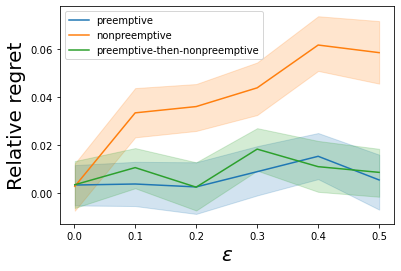

In [55]:
df = pd.read_csv('results/geo/uniform/results_geo.csv')
filt = (df['num_jobs'] == 5) & (df['service_time'] == 20000)
filtered = df[filt]
sns.lineplot(x=filtered['eps'], y=filtered['preemptive']/filtered['OPT'] -1, label='preemptive')
sns.lineplot(x=filtered['eps'], y=filtered['non-preemptive']/filtered['OPT'] -1, label='nonpreemptive')
sns.lineplot(x=filtered['eps'], y=filtered['pre-non-pre']/filtered['OPT']-1, label='preemptive-then-nonpreemptive')
plt.xlabel(r'$\epsilon$', fontsize=20)
plt.ylabel("Relative regret", fontsize=20)
plt.legend(fontsize=10)
plt.savefig('uniform-regret.pdf', bbox_inches = 'tight')

In [50]:
it_num = 100
repetition = 100

N = 5
C = 10
 
for eps in eps_list:
    for i in range(it_num):
        mean_values = np.random.uniform(0.5-eps, 0.5+eps, N)
        service_rates = sample_service_rates(N, 0.7)
        max_service_time = np.max(1/service_rates)
        S = math.floor( (max_service_time**(2/3)) * (np.log(N*max_service_time)) / C)
        
        trials_p = np.array([])
        for j in range(repetition):
            samples = [(bernoulli.rvs(mean_values[n], size=1)).tolist() for n in range(N)]
            trials_p = np.append(trials_p, preemptive(mean_values, service_rates, samples))

        trials_nonp = np.array([])
        for j in range(repetition):
            samples = [(bernoulli.rvs(mean_values[n], size=1)).tolist() for n in range(N)]
            trials_nonp = np.append(trials_nonp, nonpreemptive(mean_values, service_rates, samples))
    
        trials_pnonp = np.array([])
        for j in range(repetition):
            samples = [(bernoulli.rvs(mean_values[n], size=1)).tolist() for n in range(N)]
            trials_pnonp = np.append(trials_pnonp, preemptive_then_nonpreemptive(mean_values, service_rates, samples))
        
        pre = np.mean(trials_p)
        non = np.mean(trials_nonp)
        pre_non_pre = np.mean(trials_pnonp)
        OPT = optimal(mean_values, service_rates)
        
        df = pd.read_csv('results_geo.csv')
        df = df.append({'num_jobs': N, 'service_time': 20000, 'eps': eps, 'instance_number': i+1, 'rep_number': j+1, 
                        'OPT': OPT, 'preemptive': pre, 'non-preemptive': non, 'pre-non-pre': pre_non_pre}, 
                       ignore_index = True)
        df.to_csv('results_geo.csv', index=False)

KeyboardInterrupt: 

In [24]:
eps = 0.01
N = 5
C = 10
mean_values = np.random.uniform(0.5-eps, 0.5+eps, N)
#service_rates = sample_service_rates(N, 0.7)
service_rates = np.array([1/200 for i in range(N)])
max_service_time = np.max(1/service_rates)
S = math.floor( (max_service_time**(2/3)) * (np.log(N*max_service_time)) / C)
print(mean_values)
print(service_rates)
print(S)

[0.49175541 0.50709131 0.49419265 0.50338519 0.50464867]
[0.005 0.005 0.005 0.005 0.005]
23


In [25]:
trials_p = np.array([])
for i in range(10):
    samples = [(bernoulli.rvs(mean_values[i], size=1)).tolist() for i in range(N)]
    trials_p = np.append(trials_p, preemptive(mean_values, service_rates, samples))

trials_nonp = np.array([])
for i in range(10):
    samples = [(bernoulli.rvs(mean_values[i], size=1)).tolist() for i in range(N)]
    trials_nonp = np.append(trials_nonp, nonpreemptive(mean_values, service_rates, samples))
    
trials_pnonp = np.array([])
for i in range(10):
    samples = [(bernoulli.rvs(mean_values[i], size=1)).tolist() for i in range(N)]
    trials_pnonp = np.append(trials_pnonp, preemptive_then_nonpreemptive(mean_values, service_rates, samples))    

trials_opt = np.array([])
for i in range(10):
    trials_opt = np.append(trials_opt, optimal_rule(mean_values, service_rates))

p_average = np.mean(trials_p)
nonp_average = np.mean(trials_nonp)
pnonp_average = np.mean(trials_pnonp)
opt_average = np.mean(trials_opt)
opt = optimal(mean_values, service_rates)

print(p_average)
print(nonp_average)
print(pnonp_average)
print(opt_average)
print(opt)
print("")
print(p_average-opt)
print(nonp_average-opt)
print(pnonp_average-opt)

1558.6609490150743
1529.4477151290896
1396.8859142819638
1380.4620633964512
1492.4183824325182

66.24256658255604
37.02933269657137
-95.53246815055445
